# Numerical Integration with Quantum Amplitude Estimation

In this sample we will be integrating functions numerically using Quantum Amplitude Estimation (QAE).
Warning: This sample is intended for users with an advanced level of knowledge of mathematics.

This sample is based on the work [arXiv:2005.07711](https://arxiv.org/abs/2005.07711) by Vazquez and Woerner.

In this sample we cover techniques of visualizing results and seeing noise on hardware in action.

The basics of QAE are that we are given an operation implementation a unitary $A$ with the following properties

$$A\ket{0}_{n+1} = \sqrt{1-a}\ket{\psi_0}_n\ket{0} + \sqrt{a}\ket{\psi_1}_n\ket{1}$$

with $\psi_0$ and $\psi_1$ being arbitrary states.

From this we construct the operations implementing the following operators:

- $S_{\psi_0}, S_{\psi_1}$, which are reflections across $\psi_0$ and $\psi_1$ respectively
- $Q=A S_{\psi_0} A^\dagger S_{\psi_1}$ as the full operator

Amplitude estimation will then try to estimate $a$ given the operators $A$ and $Q$.
For this we construct a circuit where we apply $A$ followed by $k$ applications of $Q$ and in the end measure the last qubit:
$$Q^kA\ket{0}_n, k \geq 0, n \geq 2$$ 

After running the circuit multiple times we estimate $a$ to be the probability of getting result $1$.

Our results improve if we build an $A$ that has the same $a$ acts on a greater number of qubits $n$ or by increasing the number of iterations $k$.
Increasing $n$ comes at the cost of needing more qubits, whereas $k$ comes at the cost of higher circuit depth.


In [1]:
import qsharp

Preparing Q# environment...
.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy import optimize
import pandas as pd

import qsharp.azure
import datetime
from qsharp.azure import AzureJob

Below we are implementing a circuit for the numerical integral

$$\int_{x=0}^y{\sin^2(\pi x)dx} = \frac{2\pi y - \sin(2 \pi y)}{4\pi}$$

Details on this circuit can be found in the paper [arXiv:2005.07711](https://arxiv.org/abs/2005.07711).

The fundamental idea is that we 
* Discretize the interval $[0,2\pi{}]$ into points $[x_0, \ldots, x_{2^n}]$ that are spaced uniformly, where $n+1$ is the number of qubits for the circuit
* Put the quantum program in the state of the function at the discrete points
* Estimate the amplitudes at those given points
* Calculate the Riemann integral using these values

The reason amplitude estimation is effective on quantum computers is that the quantum version has quadratic speedup over its classical counterpart. 
This stems from the fact that the QAE algorithm fundamentally builds on Grover's search.

For a circuit with $n+1$ qubits, we have one target qubit and $n$ control qubits.

Our algorithm has two main components:

- State preparation $A$
- Iteration operator $Q$


In [3]:
%%qsharp

open Microsoft.Quantum.Math;
open Microsoft.Quantum.Arithmetic;
open Microsoft.Quantum.Convert;
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Diagnostics;
open Microsoft.Quantum.Measurement;

Let's build our state preparation $A$:

We prepare state using controlled $Y$-axis rotations on a target qubit. For $i \in [1,2^n]$, we control $Y$-axis rotation with angles $\theta_i = 2\pi(x_i - x_0)$ on the control qubits being in state $\ket{i}_n$. 
Additionally, we control the rotation $2\pi x_0$ on the control qubits being $\ket{0}_n$. 
The paper optimizes this to only have $n+1$ thetas, where $R_Y(\theta_0)$ is uncontrolled and $R_Y(\theta_i), i > 0$ is controlled on the $(n - i)^\text{th}$ control wire.
Due to the uniform spacing, we see $$\exists \Delta, x_i = x_0 + i * \Delta$$
Therefore it follows that the optimized version is equivalent to the version that is controlled on $\ket{i}_n, i \in [0, 2^n]$.

In [4]:
%%qsharp
operation PrepareState(theta : Double[], ctls : Qubit[], target : Qubit) : Unit is Adj + Ctl { // Corresponds to operator A
    EqualityFactI(Length(theta), Length(ctls) + 1, "Thetas and controls must have same length");
    ApplyToEachCA(H, ctls);
    Ry(theta[0], target);
    for i in IndexRange(ctls) {
        Controlled Ry([ctls[Length(ctls) - 1 - i]], (theta[i + 1], target));
    }
}

... and our Iteration operator $Q$: The iteration operator $Q$ is given as follows $$Q=A S_0 A^\dagger S_1$$ where 
$$S_0 = I_{n + 1} - 2 \ket{0}\bra{0}_{n+1}, S_1 = I_n \otimes Z$$

In [5]:
%%qsharp
operation Rotate(theta : Double[], ctls : Qubit[], target : Qubit) : Unit is Adj + Ctl { // Corresponds to operator Q
    Z(target);
    within {
        Adjoint PrepareState(theta, ctls, target);
        ApplyToEachCA(X, ctls + [target]); // Turns |0...0> into |1...1> (i.e., enabling the controlled Z to reflect)
    } apply {
        Controlled Z (ctls, target);
    }
}

The final algorithm will then be built to correspond to the matrix operation:
$$Q^kA\ket{0}_n, k \geq 0, n \geq 2$$ 

In [6]:
%%qsharp
operation EstimateAmplitude(theta : Double[], k : Int) : Result {
    use ctls = Qubit[Length(theta) - 1];
    use target = Qubit();
    PrepareState(theta, ctls, target);
    RepeatCA(Rotate, k, (theta, ctls, target));
    let res = MResetZ(target);
    ResetAll(ctls);
    return res;
}

operation CountOneResults<'TInput> (op : ('TInput => Result), n : Int , input : 'TInput) : Int {
    return Count(res -> res == One, DrawMany(op, n, input));
}

operation EstimateAmplitudeNShots(n : Int, theta : Double[], k : Int) : Int {
    return CountOneResults(EstimateAmplitude, n, (theta, k));
}


## Spin Echo Optimization

After building our $A$ and $Q$, we can use properties of quantum circuits to reduce the number of rotations by merging them.
Essentially, we can compute the inverse of our rotations through the `Z` gates, allowing us to merge the operators $A^\dagger S_1 A$.
This optimization is called Spin Echo optimization. 
Please refer to [arXiv:2005.07711](https://arxiv.org/abs/2005.07711) for more details on why it works. 


In [7]:
%%qsharp
operation RotateSpinEcho(theta : Double[], ctls : Qubit[], target : Qubit) : Unit is Adj + Ctl {
    PrepareState(Mapped(x -> 2.0 * x, theta), ctls, target);
    ApplyToEachCA(H, ctls);
    Z(target);
    within {
        ApplyToEachCA(X, ctls + [target]); // Turns |0...0> into |1...1> (i.e., enabling the controlled Z to reflect)
    } apply {
        Controlled Z (ctls, target);
    }
    
}

operation EstimateAmplitudeSpinEcho(theta : Double[], k : Int) : Result {
    use ctls = Qubit[Length(theta) - 1];
    use target = Qubit();
    RepeatCA(RotateSpinEcho, k, (theta, ctls, target));
    PrepareState(theta, ctls, target);
    ApplyToEachCA(H, ctls);
    let res = MResetZ(target);
    ResetAll(ctls);
    return res;
}

operation EstimateAmplitudeNShotsSpinEcho(n : Int, theta : Double[], k : Int) : Int {
    return CountOneResults(EstimateAmplitudeSpinEcho, n, (theta, k));
}

### Resource Estimation of Spin Echo Optimization

To see the effectiveness of the Spin Echo optimization, we will use the resource estimator to see the difference in gate count. 
For this we will use the resource estimator and for bit length 2 and 3 we will see the how many fewer gates the optimized circuit needs for given $k$.

In [8]:
from IPython.core.display import HTML

In [9]:
dfs = []
for bitlen in (2, 3):
    deltas = []
    theta = list(map(lambda _ : random.uniform(0, 3.14), range(bitlen))) # Random thetas
    for k in map(lambda x : 2 ** x, range(8)):
        spin_echo_res = EstimateAmplitudeSpinEcho.estimate_resources(theta=theta, k=k)
        res = EstimateAmplitude.estimate_resources(theta=theta, k=k)

        def delta(key : str) -> int:
            return (res[key] - spin_echo_res[key])

        delta_2q = str(np.round(delta('CNOT') / res['CNOT'] * 100, 2)) + '%'
        delta_1q = str(np.round((delta('QubitClifford') + delta('R') + delta('T')) / (res['QubitClifford'] + res['R'] + res['T']) * 100, 2)) + '%'
        deltas.append([k, delta_1q, delta_2q])
    df = pd.DataFrame(deltas, columns=["k", "1Q gate reduction", "2Q gate reduction"])
    df = df.style.set_caption(f"Differences with Spin Echo optimization at bit length {bitlen}").hide_index()
    dfs.append(df)

html_dfs = list(map(lambda df : df.to_html(), dfs))
HTML("<br>".join(html_dfs))

k,1Q gate reduction,2Q gate reduction
1,16.0%,28.57%
2,20.45%,33.33%
4,23.17%,36.36%
8,24.68%,38.1%
16,25.48%,39.02%
32,25.9%,39.51%
64,26.1%,39.75%
128,26.21%,39.88%
k,1Q gate reduction,2Q gate reduction
1,14.89%,18.18%


We see that the Spin Echo circuit requires fewer gates across the board and for higher $k$ we get bigger benefits.

## Maximum Likelihood Estimator (MLE)

We will be using the MLE to get our optimal theta results with a modified optimization function that you can see in the code below as `loglikelihood`.

To learn more about why and how this estimator works with QAE please see [arXiv:1904.10246](https://arxiv.org/pdf/1904.10246.pdf).

We use (and adapt) the MLE calculation methods from the work resulting from [arXiv:1904.10246](https://arxiv.org/pdf/1904.10246.pdf) that can be found in the [Qiskit community tutorials on GitHub](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/SimpleIntegral_AEwoPE.ipynb).

In [10]:
from typing import List, Tuple

def calculate_theta(hit_list: List[int], number: List[int], shots: List[int]) -> List[float]:
    """
        calculate optimal theta values
            hit_list: list of count of obserbving "1"
            number: list of number of Grover operators        
            shots_list: list of number of shots

        Return:
            theta_candidates: list of optimal theta
    """

    small = 1.e-15  # small valued parameter to avoid zero division
    confidence_level = 5  # confidence level to determine the search range

    theta_candidates = []
    range_min = 0.0 + small
    range_max = 1.0 - small
    for idx_grover_operator in range(len(number)):

        def loglikelihood(p):
            ret = np.zeros_like(p)
            theta = np.arcsin(np.sqrt(p))
            for n in range(idx_grover_operator + 1):
                ihit = hit_list[n]
                arg = (2 * number[n] + 1) * theta
                ret = ret + 2 * ihit * np.log(np.abs(np.sin(arg))) + 2 * (
                    shots - ihit) * np.log(np.abs(np.cos(arg)))
            return -ret

        search_range = (range_min, range_max)
        prob_candidate = optimize.brute(loglikelihood, [search_range])[0]
        theta_candidates.append(np.arcsin(np.sqrt(prob_candidate)))
        pbound = cramer_rao_bound(idx_grover_operator, shots, prob_candidate, number)
        range_max = min(prob_candidate+confidence_level * pbound, 1.0 - small)
        range_min = max(prob_candidate-confidence_level * pbound, 0.0 + small)
    return theta_candidates


def cramer_rao_bound(M: int, shots: List[int], p0: float, number: List[int]) -> float:
    """
        calculate Cramér-Rao lower bound
            M: upper limit of the sum in Fisher information 
            shots_list:  list of number of shots
            p0: the true parameter value to be estimated
            number: list of number of Grover operators        

        Return:
            square root of Cramér-Rao lower bound:  lower bound on the standard deviation of unbiased estimators
    """
    fisher_info = sum(map(lambda mk : shots / (p0 * (1 - p0)) * (2 * mk + 1)**2, number[:M+1]))
    return np.sqrt(1 / fisher_info)


With the statistical preliminaries out of the way, let's build a function that assembles our $\theta_i, i \in [0, n]$, runs our circuit and calculates the most likely values.

In [11]:
def compute_theta(bit_length: int, y_int: Tuple[float, float]) -> List[float]:
    (y0, y) = y_int
    y_scs = [i * (y - y0) / bit_length for i in range(bit_length)]
    thetas = [2 * math.pi * (y_sc - y0) for y_sc in y_scs]
    return thetas


def integrate(run_fn, bit_length: int, y_int: Tuple[float, float], ks: List[int], shots=250) -> List[float]:
    prev = 0
    (_, y) = y_int
    print(f"integration for y in {y_int}")
    # Precompute thetas
    theta = compute_theta(bit_length=bit_length, y_int=y_int)
    # Run Amplitude estimation
    good_states = []
    for k in ks:
        good_states.append(run_fn(n=shots, theta=theta, k=k, y_int=y_int))
    result_thetas = calculate_theta(good_states, ks, shots)
    return list(map(lambda x: x * y, result_thetas))


We then proceed to actually integrate our work and collect data.

In [12]:
from IPython.display import clear_output
n = 15
ys = list(map(lambda x : 0.5 * x / n, list(range(n + 1))))
ks = [0, 1, 2, 4, 8, 16]

def get_results(run_fn, bit_length=2, ys=ys, ks=ks, shots=200):
    k_vals = dict()
    for k in ks:
        k_vals[k] = []
    prev = ys[0]
    for y in ys: 
        res = list(integrate(run_fn, bit_length=2, y_int=(0, y), shots=200, ks=ks))
        assert len(ks) == len(res)
        for i in range(len(ks)):
            k_vals[ks[i]] += [res[i]]
        prev = y
    return k_vals

In [13]:
k_vals = get_results(EstimateAmplitudeNShotsSpinEcho.simulate)

integration for y in (0, 0.0)
integration for y in (0, 0.03333333333333333)
integration for y in (0, 0.06666666666666667)
integration for y in (0, 0.1)
integration for y in (0, 0.13333333333333333)
integration for y in (0, 0.16666666666666666)
integration for y in (0, 0.2)
integration for y in (0, 0.23333333333333334)
integration for y in (0, 0.26666666666666666)
integration for y in (0, 0.3)
integration for y in (0, 0.3333333333333333)
integration for y in (0, 0.36666666666666664)
integration for y in (0, 0.4)
integration for y in (0, 0.43333333333333335)
integration for y in (0, 0.4666666666666667)
integration for y in (0, 0.5)


Now we'll plot our approximations for different values of $k$ against the exact integral

In [14]:
def f(x : float) -> float:
    return (math.sin(math.pi * x)) ** 2

def int_f(x : float) -> float:
    return x / 2 - math.sin(2 * math.pi *x) / (4 * math.pi)

In [15]:
colors = dict()
colors[0] = 'b'
colors[1] = 'r'
colors[2] = 'c'
colors[4] = 'm'
colors[8] = 'y'
colors[16] = 'pink'
colors[32] = 'grey'

In [16]:
def plot(ys : list, k_vals : dict) -> None:
    int_f_y = list(map(int_f, ys))
    f_y = list(map(f, ys))
    fig, ax = plt.subplots()
    ax.set_xlabel('y')
    int_fx_plot, = plt.plot(ys, int_f_y, color='g', label='$g(y) = \int_{x=0}^y \sin^2(\pi x) dx$')
    apprx_plots = []
    for k, vals in k_vals.items(): 
        f_vals = list(map(lambda x : x / 1, vals))
        apprx_plot, = plt.plot(ys, f_vals, colors[k], label='$\widehat{g(y)}, ' + f'k={k}$')
        apprx_plots.append(apprx_plot)
    ax.legend(handles=[int_fx_plot] + apprx_plots)

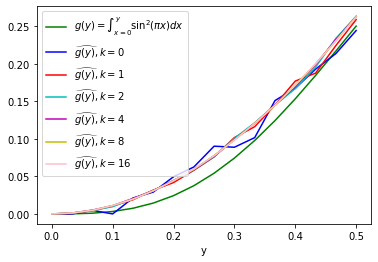

In [17]:
plot(ys, k_vals)

In this plot we see that all of our results look fairly close to the expected value graphed in green.

Therefore, we'll graph the errors to get see which $k$ performs best.

In [18]:
def loss(x : float, expected : float) -> float: 
    return (x - expected) ** 2

def compute_err(ys : list, vals : list) -> list:
    assert len(ys) == len(vals)
    err = []
    f_y = list(map(f, ys))
    int_f_y = list(map(int_f, ys))
    err = [loss(g_hat_y, g_y) for g_hat_y, g_y in zip(vals, int_f_y)]
    return err

def plot_err(ys, k_err : dict) -> None:
    fig, ax = plt.subplots()
    ax.set_xlabel('y')
    ax.set_ylabel('error')
    err_plots = []
    for k, err in k_err.items():  
        err_plot, = plt.plot(ys, err, colors[k], label='$L(\hat{y}, y)$, ' + f'k={k}')
        err_plots.append(err_plot)
    ax.legend(handles=err_plots)

def plot_average_err(k_err_avg : dict) -> None:
    fig, ax = plt.subplots()
    ax.set_xlabel('$k$')
    ax.set_ylabel('Frequentis risk (average error)')
    plt.bar(list(map(lambda x : str(x), k_err_avg.keys())), k_err_avg.values())

def build_err(ys : list, k_vals : dict) -> tuple:
    k_err = dict()
    k_err_avg = dict()
    for k, vals in k_vals.items():
        f_vals = list(map(lambda x : f(x) / 2, vals))
        k_err[k] = compute_err(ys, f_vals)
        k_err_avg[k] = np.average(k_err[k])
    return (k_err, k_err_avg)

In [19]:
k_err, k_err_avg = build_err(ys, k_vals)

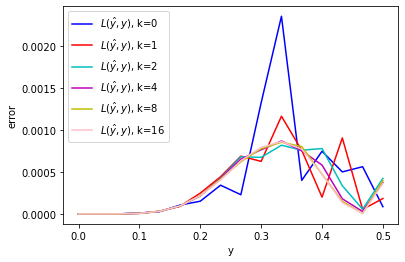

In [20]:
plot_err(ys, k_err)

Here we clearly see that $k=0$ performs worse than the other values. Let's look at the average error to get a better picture.

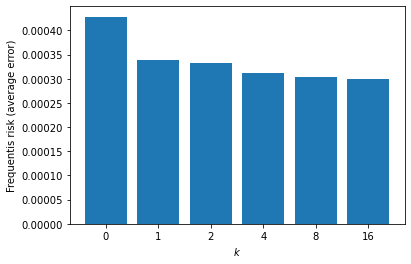

In [21]:
plot_average_err(k_err_avg)

As we'd expect, the error is trending downward with increasing $k$.

Let us now repeat the same on IonQ Harmony to see if the results are the same.

First, we will connect to the Azure Quantum service and select the IonQ harmony target.

In [ ]:
targets = qsharp.azure.connect(
    resourceId="",
    location=""
)

In [24]:
print(f"This workspace has {len(targets)} targets:")
for target in targets:
    print(f"- {target.id} (average queue time {datetime.timedelta(seconds=target.average_queue_time)})")

This workspace has 10 targets:
- ionq.qpu (average queue time 0:01:13)
- ionq.qpu.aria-1 (average queue time 3:40:44)
- ionq.simulator (average queue time 0:00:02)
- quantinuum.hqs-lt-s1 (average queue time 0:00:00)
- quantinuum.hqs-lt-s1-apival (average queue time 0:00:01)
- quantinuum.hqs-lt-s2 (average queue time 0:00:00)
- quantinuum.hqs-lt-s2-apival (average queue time 0:00:01)
- quantinuum.hqs-lt-s1-sim (average queue time 3:47:43)
- quantinuum.hqs-lt-s2-sim (average queue time 0:02:33)
- quantinuum.hqs-lt (average queue time 0:00:00)


In [25]:
qsharp.azure.target("ionq.qpu")

Loading package Microsoft.Quantum.Providers.IonQ and dependencies...
Active target is now ionq.qpu


{'id': 'ionq.qpu', 'current_availability': {}, 'average_queue_time': 73}

Now we write some logic to handle our jobs. Since jobs submitted to real hardware might take a bit to complete, we want to have infrastructure to submit jobs, check their status and fetch their results.

In [26]:
def submit_integration_jobs_yint(bit_length: int, y_int: tuple, ks, shots=250):
    theta = compute_theta(bit_length=bit_length, y_int=y_int)
    # Run Amplitude estimation
    k_jobs = dict()
    for k in ks:
        k_jobs[k] = qsharp.azure.submit(EstimateAmplitudeSpinEcho, jobName = f"QAE for bit length {bit_length}, k={k}, y_int={y_int}", shots=shots, theta=theta, k=k)
    return k_jobs

def submit_integration_jobs(bit_length: int, ys : list, ks, shots=250):
    y_k_jobs = dict()
    for y in ys:
        y_int = (0, y)
        y_k_jobs[y_int] = submit_integration_jobs_yint(bit_length, y_int, ks, shots)
    return y_k_jobs

def get_job(job_id : str) -> tuple:
    current_job = qsharp.azure.status(jobId=job_id)
    succeeded = current_job.status == 'Succeeded'
    if succeeded:
        print(f'Job completed')
    elif current_job.status == 'Failed':
        print(f'Job \"{current_job.name}\" failed. Please review reason at {current_job.uri}')
    else:
        print(f'Job \"{current_job.name}\" is still running. Please check back later!')
    return (succeeded, current_job)


def get_job_result(job_id : str, shots : int) -> int:
    (success, _) = get_job(job_id=job_id)
    if not success:
        raise Exception("Job not completed")
    output = qsharp.azure.output(jobId=job_id)
    if '1' not in output: # All 0 return
        return 0
    return np.round(output['1'] * shots)


def get_all_job_results(y_k_jobs : dict, shots=250) -> dict:
    y_k_job_result = dict()
    for (y, k_jobs) in y_k_jobs.items():
        y_k_job_result[y] = dict()
        for (k, job) in k_jobs.items():
            y_k_job_result[y][k] = get_job_result(job_id=job.id, shots=shots)
    return y_k_job_result

def build_use_job_output(y_k_job_result : dict):
    def use_job_output(n : int, theta : list, k : int, y_int : tuple) -> int:
        return y_k_job_result[y_int][k]
    return use_job_output


Let's go ahead and run them!


**Please note that this sample makes use of paid services on Azure Quantum. 
The cost of running this sample with the provided parameters on IonQ is approximately \$147. 
This quantity is only an approximate estimate and should not be used as a binding reference. 
The cost of the service might vary depending on your region, demand and other factors.**

Please note this might take a while. Please keep the tab with the sample open until completion.

In [27]:
#y_k_jobs = submit_integration_jobs(bit_length=2,ys=ys,ks=ks)

clear_output(wait=True)
print("Submitted all jobs successfully!")

Submitted all jobs successfully!


In [28]:
import pickle


In [29]:
with open('jobs-qpu.pkl', 'wb') as pkl_file:
    pickle.dump(y_k_jobs, pkl_file)


In [33]:
with open('jobs-qpu.pkl', 'rb') as pkl_file:
    y_k_jobs = pickle.load(pkl_file)

In [37]:
y_k_job_results = get_all_job_results(y_k_jobs,)
clear_output(wait=True)
print("Processed all results successfully!")

Processed all results successfully!


Once we're done, we will get our results.


In [38]:
k_vals_aq = get_results(build_use_job_output(y_k_job_results))

integration for y in (0, 0.0)
integration for y in (0, 0.03333333333333333)
integration for y in (0, 0.06666666666666667)
integration for y in (0, 0.1)
integration for y in (0, 0.13333333333333333)
integration for y in (0, 0.16666666666666666)
integration for y in (0, 0.2)
integration for y in (0, 0.23333333333333334)
integration for y in (0, 0.26666666666666666)
integration for y in (0, 0.3)
integration for y in (0, 0.3333333333333333)
integration for y in (0, 0.36666666666666664)
integration for y in (0, 0.4)
integration for y in (0, 0.43333333333333335)
integration for y in (0, 0.4666666666666667)
integration for y in (0, 0.5)


Let's now graph our results/errors and see if they differ from our findings on the simulator!

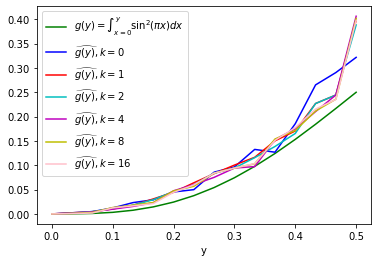

In [39]:
plot(ys, k_vals_aq)

In [40]:
k_err, k_err_avg = build_err(ys, k_vals_aq)

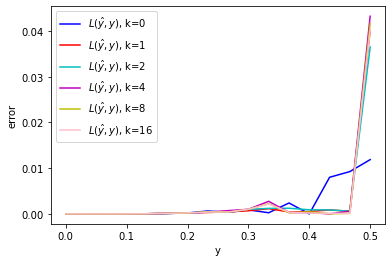

In [41]:
plot_err(ys, k_err)

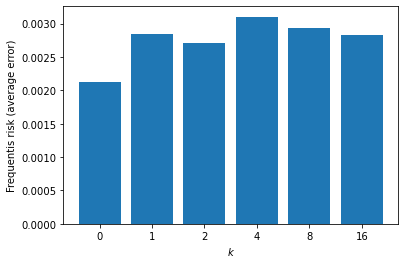

In [42]:
plot_average_err(k_err_avg)

In our graph we see our results are not as on the simulator. 
In fact, in our testing $k=0$ performed better than any other $k$.
This comes down to the noise incurred by the additional gates that we need to apply for the larger values of $k$.
This is an interesting result because it shows considerations for current quantum computers that a perfect simulator does not depict: Every gate introduces noise.
As a result, one of our goals must be to reduce circuit depth. 
Despite having the reduced depth already using the spin echo optimization, we still have noise effects. 
Without this optimization's circuit depth reduction we'd expect noise to be even higher.
But we can see that even with very few qubits and high noise we were able to approximate our integral quite closely.
That means that there is a lot more to explore with what we can do on current hardware.
